In [188]:
#hide
!pip install -Uqq fastbook
import fastbook
#fastbook.setup_book()

In [189]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

## Pixels: The Foundations of Computer Vision

## Sidebar: Tenacity and Deep Learning

## End sidebar

In [190]:
path = untar_data(URLs.MNIST_SAMPLE)

In [191]:
#hide
Path.BASE_PATH = path

In [192]:
path

Path('.')

In [193]:
type(path)

pathlib.PosixPath

In [194]:
path.ls?

In [195]:
path.ls??

In [196]:
doc(path.ls)

In [197]:
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [198]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [199]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [200]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [201]:
type(im3)

PIL.PngImagePlugin.PngImageFile

In [202]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [203]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [204]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:27,4:27])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0,0,0,0,0,0


## First Try: Pixel Similarity

In [205]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

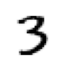

In [206]:
show_image(three_tensors[1]);

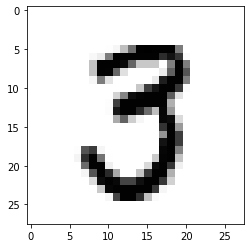

In [207]:
from  matplotlib import pyplot as plt
plt.imshow(three_tensors[2])

In [208]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [209]:
len(stacked_threes.shape)

3

In [210]:
stacked_threes.ndim

3

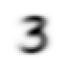

In [211]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

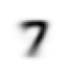

In [212]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

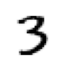

In [213]:
a_3 = stacked_threes[1]
show_image(a_3);

In [214]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [215]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [216]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy Arrays and PyTorch Tensors

In [217]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [218]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [219]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [220]:
tns[1]

tensor([4, 5, 6])

In [221]:
tns[:,1]

tensor([2, 5])

In [222]:
tns[1,1:3]

tensor([5, 6])

In [223]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [224]:
type(tns)

torch.Tensor

In [225]:
tns.type()

'torch.LongTensor'

In [226]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting

In [227]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [228]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [229]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1262, 0.1611, 0.1319,  ..., 0.1654, 0.1285, 0.1230]),
 torch.Size([1010]))

In [230]:
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

In [231]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [232]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [233]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [234]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [235]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

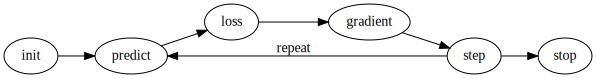

In [236]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [237]:
def f(x): return x**2

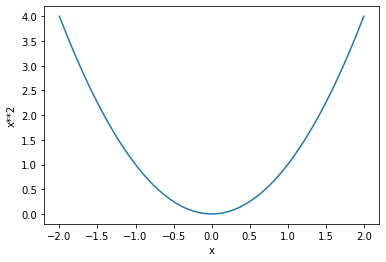

In [238]:
plot_function(f, 'x', 'x**2')

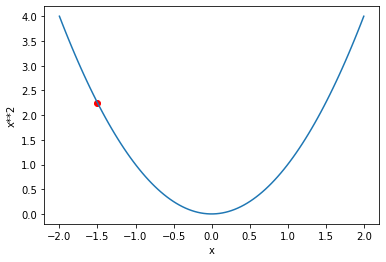

In [239]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

### Calculating Gradients

In [240]:
xt = tensor(3.).requires_grad_()

In [241]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [242]:
yt.backward()

In [243]:
xt.grad

tensor(6.)

In [244]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [245]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [246]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate

### An End-to-End SGD Example

In [247]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

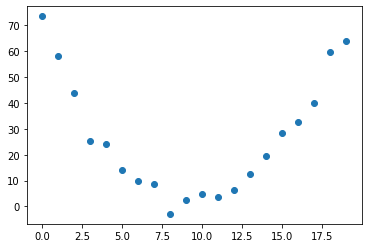

In [248]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [249]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [250]:
def mse(preds, targets): return ((preds-targets)**2).mean()

#### Step 1: Initialize the parameters

In [251]:
params = torch.randn(3).requires_grad_()

In [252]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [253]:
preds = f(time, params)

In [254]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

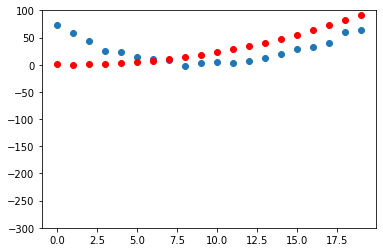

In [255]:
show_preds(preds)

#### Step 3: Calculate the loss

In [256]:
loss = mse(preds, speed)
loss

tensor(978.4811, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In [257]:
loss.backward()
params.grad

tensor([6098.6118,  385.2003,    7.0187])

In [258]:
params.grad * 1e-5

tensor([6.0986e-02, 3.8520e-03, 7.0187e-05])

In [259]:
params

tensor([ 0.2826, -0.5680,  0.4640], requires_grad=True)

#### Step 5: Step the weights. 

In [260]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [261]:
preds = f(time,params)
mse(preds, speed)

tensor(710.5535, grad_fn=<MeanBackward0>)

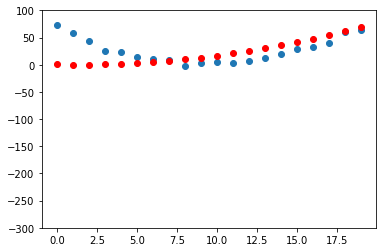

In [262]:
show_preds(preds)

In [263]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [264]:
for i in range(10): apply_step(params)

710.5535278320312
659.8499755859375
650.2518310546875
648.4320678710938
648.0842895507812
648.0150146484375
647.9983520507812
647.9917602539062
647.9869995117188
647.9825439453125


In [265]:
#hide
params = orig_params.detach().requires_grad_()

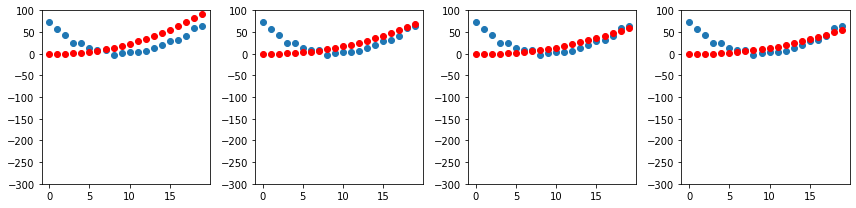

In [266]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

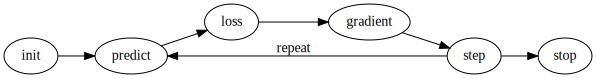

In [267]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [268]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [269]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [270]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [271]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [272]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [273]:
weights = init_params((28*28,1))

In [274]:
bias = init_params(1)

In [275]:
(train_x[0]*weights.T).sum() + bias

tensor([-2.0718], grad_fn=<AddBackward0>)

In [276]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ -2.0718],
        [  4.6982],
        [  5.1459],
        ...,
        [-16.7550],
        [ -4.0665],
        [-16.7869]], grad_fn=<AddBackward0>)

In [277]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]])

In [278]:
corrects.float().mean().item()

0.6635205149650574

In [279]:
weights[0] *= 1.0001

In [280]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.6635205149650574

In [281]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [282]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [283]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [284]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [285]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

### Sigmoid

In [286]:
def sigmoid(x): return 1/(1+torch.exp(-x))

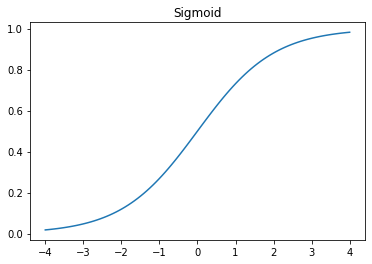

In [287]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [288]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [289]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([10, 12,  9, 14,  2]),
 tensor([ 3,  4,  6, 13,  7]),
 tensor([ 8, 11,  0,  5,  1])]

In [290]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [291]:
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [292]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 5,  9,  8, 15,  4, 24]), ('f', 'j', 'i', 'p', 'e', 'y')),
 (tensor([ 0, 18, 12, 10,  6, 20]), ('a', 's', 'm', 'k', 'g', 'u')),
 (tensor([17, 16, 23, 13,  3, 14]), ('r', 'q', 'x', 'n', 'd', 'o')),
 (tensor([21, 22,  7, 19,  1,  2]), ('v', 'w', 'h', 't', 'b', 'c')),
 (tensor([11, 25]), ('l', 'z'))]

In [293]:
string.ascii_uppercase

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [294]:
ds_mine = list(enumerate(string.ascii_uppercase))
ds_mine

[(0, 'A'),
 (1, 'B'),
 (2, 'C'),
 (3, 'D'),
 (4, 'E'),
 (5, 'F'),
 (6, 'G'),
 (7, 'H'),
 (8, 'I'),
 (9, 'J'),
 (10, 'K'),
 (11, 'L'),
 (12, 'M'),
 (13, 'N'),
 (14, 'O'),
 (15, 'P'),
 (16, 'Q'),
 (17, 'R'),
 (18, 'S'),
 (19, 'T'),
 (20, 'U'),
 (21, 'V'),
 (22, 'W'),
 (23, 'X'),
 (24, 'Y'),
 (25, 'Z')]

In [295]:
dl_mine = DataLoader(ds_mine, batch_size=6, shuffle=True)
list(dl_mine)

[(tensor([ 1,  4, 21,  5, 17, 24]), ('B', 'E', 'V', 'F', 'R', 'Y')),
 (tensor([23,  9, 22, 13,  2,  6]), ('X', 'J', 'W', 'N', 'C', 'G')),
 (tensor([16, 12, 14,  7, 20, 15]), ('Q', 'M', 'O', 'H', 'U', 'P')),
 (tensor([ 8, 18,  3,  0, 25, 19]), ('I', 'S', 'D', 'A', 'Z', 'T')),
 (tensor([11, 10]), ('L', 'K'))]

## Putting It All Together

In [296]:
weights = init_params((28*28,1))
bias = init_params(1)

In [297]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [298]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [299]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [300]:
linear1??

In [301]:
preds = linear1(batch)
preds

tensor([[11.5121],
        [ 5.2608],
        [14.8274],
        [ 1.7775]], grad_fn=<AddBackward0>)

In [302]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.0374, grad_fn=<MeanBackward0>)

In [303]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0056), tensor([-0.0322]))

In [304]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [305]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0112), tensor([-0.0644]))

In [306]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0169), tensor([-0.0966]))

In [307]:
weights.grad.zero_()
bias.grad.zero_();

In [308]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [309]:
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [310]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [311]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [312]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [313]:
validate_epoch(linear1)

0.4623

In [314]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6578

In [315]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.7856 0.9125 0.9438 0.9589 0.9614 0.9609 0.9643 0.9687 0.9702 0.9716 0.9731 0.9731 0.9746 0.9751 0.9761 0.9765 0.977 0.977 0.9785 0.9785 

### Creating an Optimizer

In [316]:
linear_model = nn.Linear(28*28,1)

In [317]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [318]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [319]:
opt = BasicOptim(linear_model.parameters(), lr)

In [320]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [321]:
validate_epoch(linear_model)

0.5727

In [322]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [323]:
train_model(linear_model, 20)

0.4932 0.8667 0.8305 0.9101 0.9321 0.9448 0.9541 0.9629 0.9648 0.9668 0.9687 0.9712 0.9731 0.9746 0.9756 0.9761 0.9775 0.9775 0.9775 0.9785 

In [324]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8203 0.8437 0.9136 0.9341 0.9477 0.955 0.9629 0.9653 0.9672 0.9692 0.9716 0.9746 0.9751 0.9756 0.9765 0.9775 0.978 0.9785 0.9785 

In [325]:
dls = DataLoaders(dl, valid_dl)

In [326]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [327]:
mnist_loss??, batch_accuracy??

In [328]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636842,0.503686,0.495584,00:00
1,0.628574,0.296750,0.708047,00:00
2,0.229619,0.305099,0.691364,00:00
3,0.099120,0.141723,0.874387,00:00
4,0.050505,0.092982,0.919529,00:00
5,0.031595,0.070995,0.937684,00:00
6,0.023792,0.058302,0.950932,00:00
7,0.020357,0.050134,0.958292,00:00
8,0.018673,0.044561,0.963199,00:00
9,0.017711,0.040563,0.965653,00:00


## Adding a Nonlinearity

In [329]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [330]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

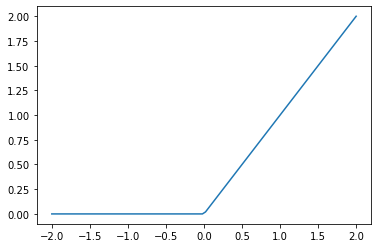

In [331]:
plot_function(F.relu)

In [332]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [333]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [334]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.244247,0.413080,0.505397,00:00
1,0.122437,0.203607,0.829735,00:00
2,0.071252,0.107397,0.923945,00:00
3,0.049022,0.074642,0.942591,00:00
4,0.038376,0.059132,0.958292,00:00
5,0.032724,0.050266,0.964181,00:00
6,0.029347,0.044610,0.965162,00:00
7,0.027085,0.040700,0.967125,00:00
8,0.025423,0.037830,0.969578,00:00
9,0.024123,0.035625,0.971050,00:00


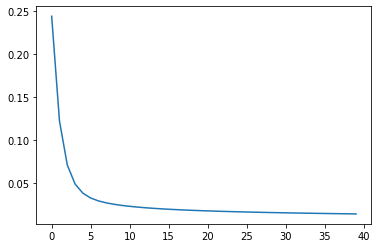

In [335]:
plt.plot(L(learn.recorder.values).itemgot(0)); #loss

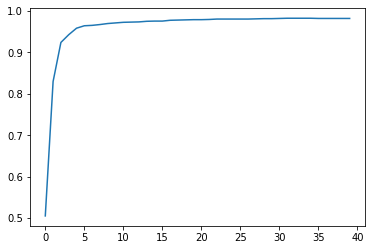

In [336]:
plt.plot(L(learn.recorder.values).itemgot(2)); #valid acc

In [337]:
learn.recorder.values

[(#3) [0.24424679577350616,0.41308048367500305,0.5053974390029907],
 (#3) [0.12243717908859253,0.203606516122818,0.8297350406646729],
 (#3) [0.07125210762023926,0.10739720612764359,0.9239450693130493],
 (#3) [0.049022186547517776,0.0746418908238411,0.9425907731056213],
 (#3) [0.038375988602638245,0.059132445603609085,0.9582924246788025],
 (#3) [0.03272372856736183,0.050265803933143616,0.964180588722229],
 (#3) [0.029347466304898262,0.04461010918021202,0.965161919593811],
 (#3) [0.02708500809967518,0.04070020467042923,0.9671246409416199],
 (#3) [0.025423191487789154,0.0378296859562397,0.9695780277252197],
 (#3) [0.02412279136478901,0.0356251485645771,0.9710500240325928],
 (#3) [0.023064235225319862,0.03386484459042549,0.9725220799446106],
 (#3) [0.022176992148160934,0.03241988644003868,0.9730127453804016],
 (#3) [0.021419452503323555,0.03120320849120617,0.9735034108161926],
 (#3) [0.020762518048286438,0.030155479907989502,0.9749754667282104],
 (#3) [0.020185496658086777,0.02923872694373

In [339]:
learn.recorder.values[-1][2]

0.981844961643219

In [340]:
m = learn.model
m

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [343]:
print(m[0])
w, b = m[0].parameters()
w, b

Linear(in_features=784, out_features=30, bias=True)


(Parameter containing:
 tensor([[-0.0025,  0.0338, -0.0205,  ..., -0.0197, -0.0012, -0.0233],
         [-0.0307, -0.0065,  0.0022,  ..., -0.0266, -0.0288, -0.0226],
         [ 0.0175,  0.0343,  0.0145,  ..., -0.0343, -0.0006,  0.0296],
         ...,
         [-0.0203, -0.0123, -0.0323,  ...,  0.0263,  0.0048, -0.0343],
         [ 0.0117, -0.0191, -0.0043,  ...,  0.0246, -0.0016, -0.0355],
         [-0.0301,  0.0059, -0.0226,  ...,  0.0253,  0.0198, -0.0145]], requires_grad=True),
 Parameter containing:
 tensor([-0.0309,  0.0910, -0.0197,  0.0061, -0.0524,  0.0713,  0.0149, -0.0019,  0.0355, -0.0182,  0.1110, -0.0240, -0.0093,  0.1084, -0.0319,  0.0519, -0.0262,  0.1057,  0.0714,  0.1178,  0.0545,
         -0.0269,  0.0598, -0.0480,  0.0033,  0.0139,  0.1035,  0.0596, -0.0680, -0.0172], requires_grad=True))

In [344]:
w.shape, b.shape

(torch.Size([30, 784]), torch.Size([30]))

/usr/local/lib/python3.6/dist-packages/fastai/torch_core.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if ax is None: _,ax = plt.subplots(figsize=figsize)


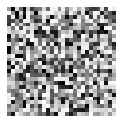

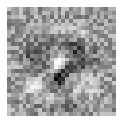

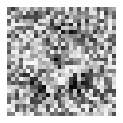

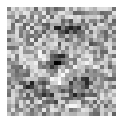

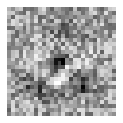

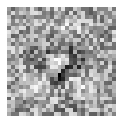

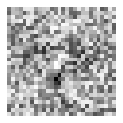

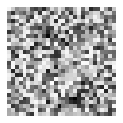

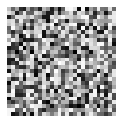

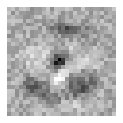

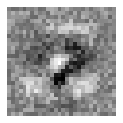

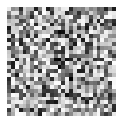

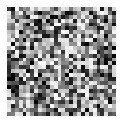

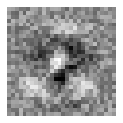

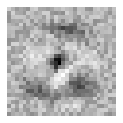

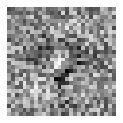

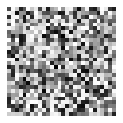

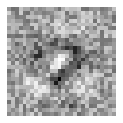

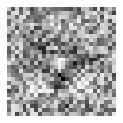

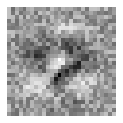

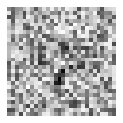

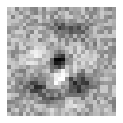

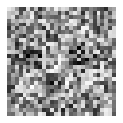

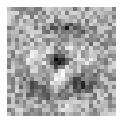

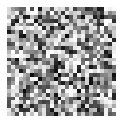

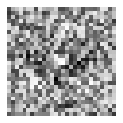

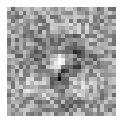

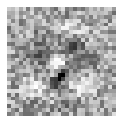

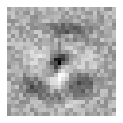

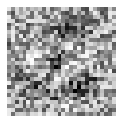

In [364]:
for i in range(30):
  show_image(w[i].view(28, 28), figsize=(2,2))

In [178]:
doc(L)

### Going Deeper

In [173]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.084675,0.013644,0.997056,00:16


## Jargon Recap

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

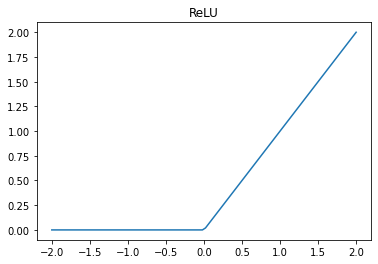

In [398]:
plot_function(F.relu, title='ReLU', min=-2, max=2)

In [392]:
list(zip([1,2,3,4] , list('abcd')))

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]

In [385]:
L([1,2,3,4] , list('abcd'))

(#2) [[1, 2, 3, 4],['a', 'b', 'c', 'd']]

In [382]:
list('abcd')

['a', 'b', 'c', 'd']

In [369]:
len(tensor([1,2,3]).shape)

1

In [373]:
k = tensor([[1,2,3],[4,5,6],[7,8,9]])
len(k.shape) #rank
k = k*2
print(k)
k[1:,1:]

tensor([[ 2,  4,  6],
        [ 8, 10, 12],
        [14, 16, 18]])


tensor([[10, 12],
        [16, 18]])

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.